In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.pntx import PointCrossover  # или другой бинарный кроссовер
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.problem import Problem
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = './data/'
WEEL_INFO = 'wear_data_train.csv'
SERVICE_INFO = 'service_dates.csv'
start_date = '2023-01-01'
end_date = '2025-09-30'
target = 'wear_intensity'

In [3]:
df = pd.read_csv(DATA_PATH + 'dataset.csv')

In [4]:
df = df.dropna(subset=[target])

df['locomotive_number'] = df['locomotive_number'].astype(str)
categorical_features = (
    df.select_dtypes(include=['object', 'string']).columns.tolist()
)
numeric_cols = df.drop(columns=categorical_features).columns.tolist()
print('Категориальные признаки:\n  ', '\n   '.join(categorical_features))
print('\nЧисловые признаки:\n  ', '\n   '.join(numeric_cols))


Категориальные признаки:
   locomotive_series
   locomotive_number
   depo
   directorate

Числовые признаки:
   steel_num
   mileage_start
   wear_intensity
   total_service_type_1
   total_service_type_2
   total_service_type_3
   total_service_type_4
   days_since_last_type_1
   days_since_last_type_2
   days_since_last_type_3
   days_since_last_type_4
   mean_days_between_type_1
   min_days_between_type_1
   max_days_between_type_1
   mean_days_between_type_2
   min_days_between_type_2
   max_days_between_type_2
   mean_days_between_type_3
   min_days_between_type_3
   max_days_between_type_3
   mean_days_between_type_4
   min_days_between_type_4
   max_days_between_type_4
   total_service_count
   service_rate_per_month
   age_days
   days_since_last_service
   service_frequency_trend


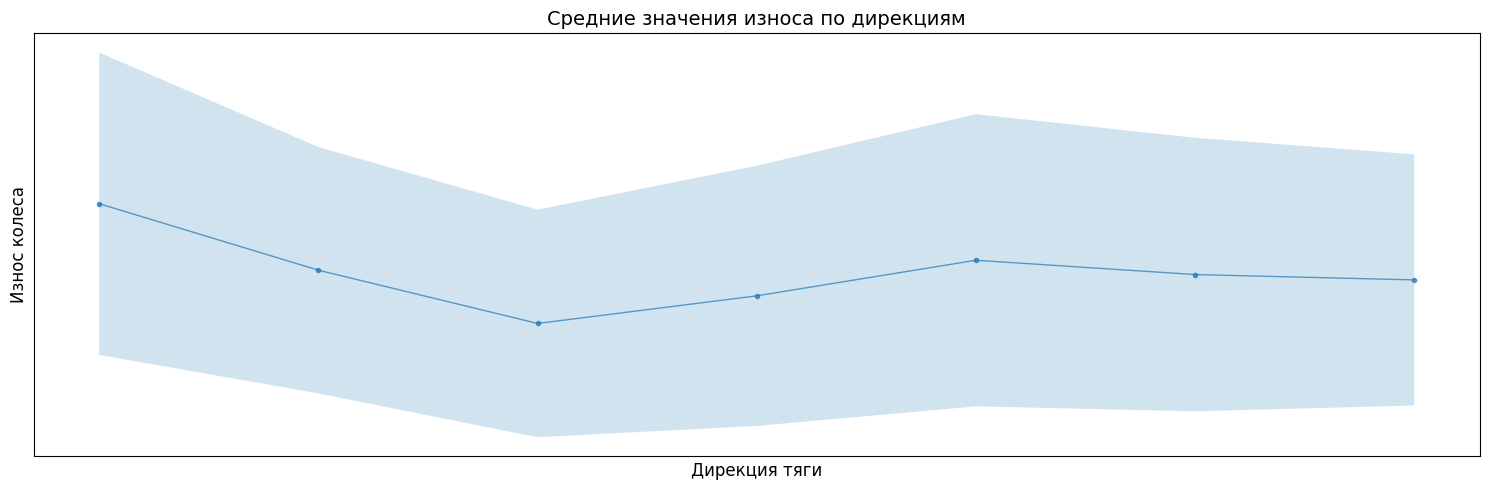

In [5]:
plt.figure(figsize=(15, 5))

means = df.groupby('directorate')[target].mean()
stds = df.groupby('directorate')[target].std()

plt.plot(means.index, means.values, 'o-', markersize=3, linewidth=1, alpha=0.7)
plt.fill_between(means.index, 
                 means.values - stds.values, 
                 means.values + stds.values, 
                 alpha=0.2)

plt.title('Средние значения износа по дирекциям', fontsize=14)
plt.xlabel('Дирекция тяги', fontsize=12)
plt.ylabel('Износ колеса', fontsize=12)

plt.xticks([])
plt.yticks([])

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

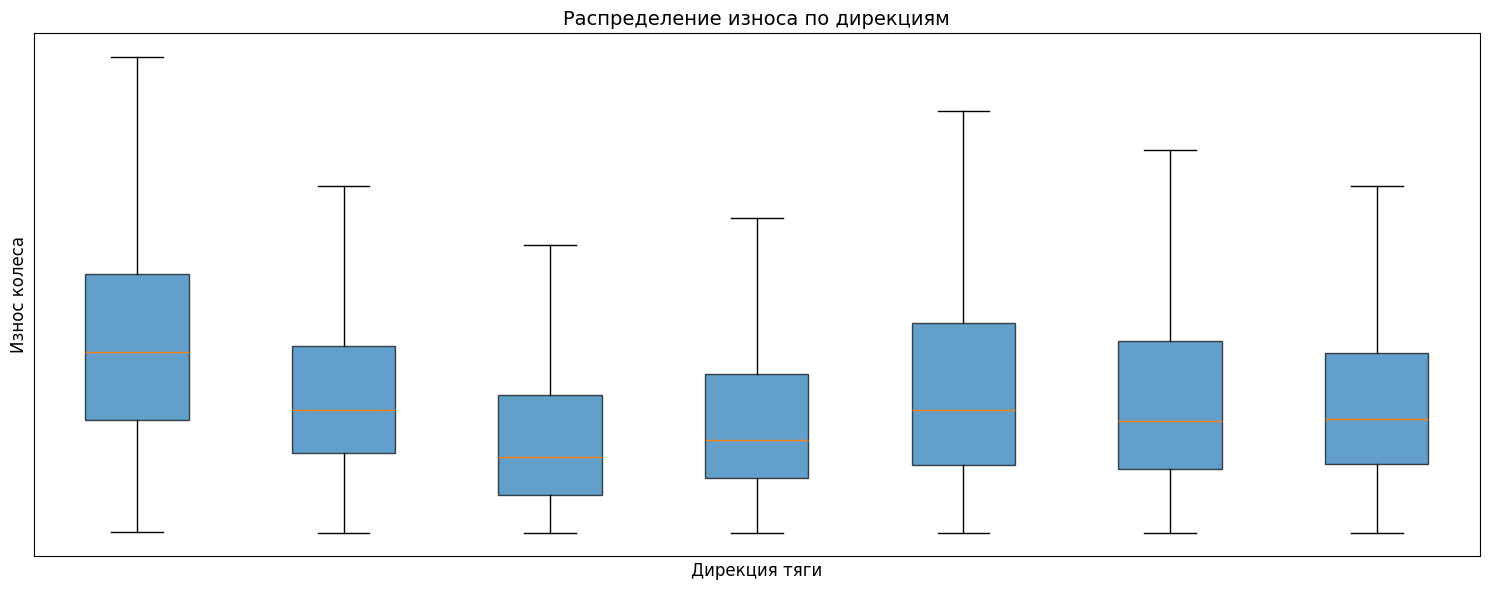

In [6]:
plt.figure(figsize=(15, 6))

data_to_plot = [group[target].values for name, group in df.groupby('directorate')]

bp = plt.boxplot(data_to_plot, patch_artist=True, showfliers=False)

for box in bp['boxes']:
    box.set_alpha(0.7)

plt.title('Распределение износа по дирекциям', fontsize=14)
plt.xlabel('Дирекция тяги', fontsize=12)
plt.ylabel('Износ колеса', fontsize=12)

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

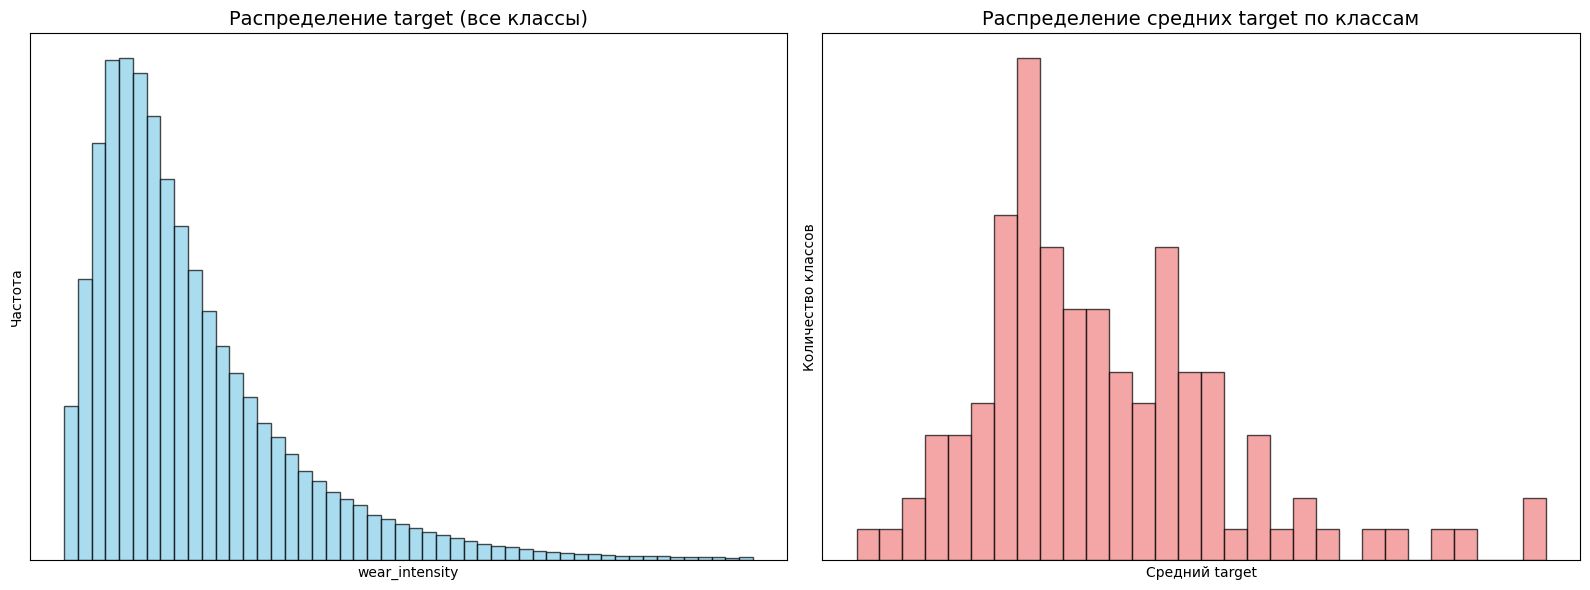

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: распределение target
axes[0].hist(df[target], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение target (все классы)', fontsize=14)
axes[0].set_xlabel(target)
axes[0].set_ylabel('Частота')

# График 2: распределение средних по классам
means = df.groupby('depo')[target].mean()
axes[1].hist(means, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Распределение средних target по классам', fontsize=14)
axes[1].set_xlabel('Средний target')
axes[1].set_ylabel('Количество классов')

# Убираем подписи на ВСЕХ графиках
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

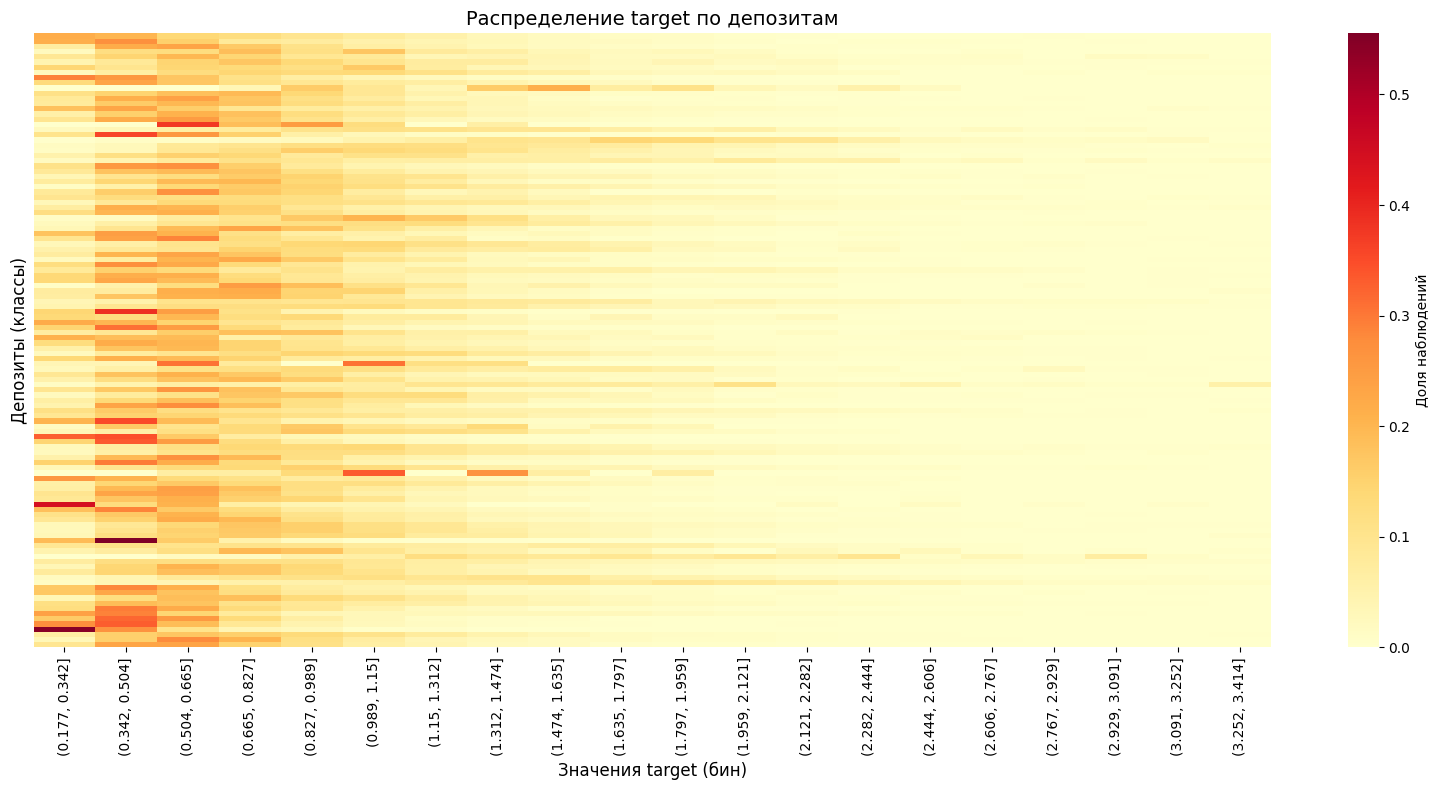

In [8]:
# Создаем сводную таблицу для тепловой карты
# Нормируем распределение target по депозитам
pivot_data = pd.crosstab(df['depo'], 
                         pd.cut(df[target], bins=20), 
                         normalize='index')

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', cbar_kws={'label': 'Доля наблюдений'})
plt.title('Распределение target по депозитам', fontsize=14)
plt.xlabel('Значения target (бин)', fontsize=12)
plt.ylabel('Депозиты (классы)', fontsize=12)

# Убираем подписи классов
plt.yticks([])

plt.tight_layout()
plt.show()

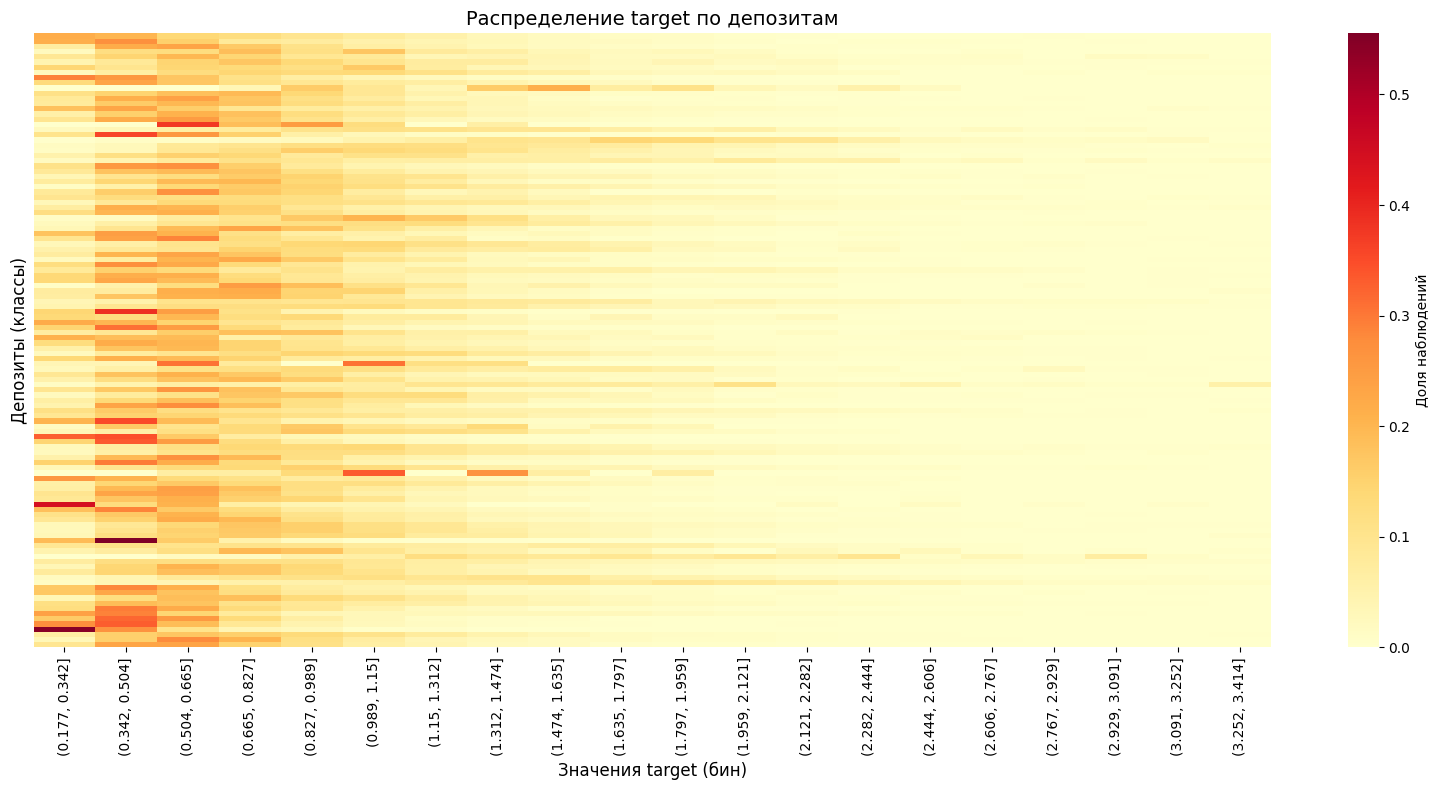

In [9]:
# Создаем сводную таблицу для тепловой карты
# Нормируем распределение target по депозитам
pivot_data = pd.crosstab(df['depo'], 
                         pd.cut(df[target], bins=20), 
                         normalize='index')

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', cbar_kws={'label': 'Доля наблюдений'})
plt.title('Распределение target по депозитам', fontsize=14)
plt.xlabel('Значения target (бин)', fontsize=12)
plt.ylabel('Депозиты (классы)', fontsize=12)

# Убираем подписи классов
plt.yticks([])

plt.tight_layout()
plt.show()

In [10]:
y_train, y_test, X_train, X_test = train_test_split(
    df[target], 
    df.drop(target, axis=1), 
    test_size=0.2,        # 20% на тест
    random_state=42       # для воспроизводимости
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Train: (326135, 31), Test: (81534, 31)
y_train: (326135,), y_test: (81534,)


In [11]:
model = CatBoostRegressor(
    iterations=1000,        # количество деревьев (по умолчанию)
    learning_rate=0.03,     # скорость обучения (по умолчанию)
    depth=6,                # глубина деревьев (по умолчанию)
    l2_leaf_reg=3.0,        # L2-регуляризация (по умолчанию)
    loss_function='RMSE',   # функция потерь для регрессии
    eval_metric='MAPE',    # функция потерь для валидации
    random_seed=42,         # для воспроизводимости
    verbose=100             # вывод каждые 100 итераций
)

In [13]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True, cat_features=categorical_features, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2886445	test: 0.2878976	best: 0.2878976 (0)	total: 134ms	remaining: 2m 14s
50:	learn: 0.2361583	test: 0.2302581	best: 0.2302581 (50)	total: 2.36s	remaining: 43.9s
100:	learn: 0.2302739	test: 0.2240964	best: 0.2240964 (100)	total: 5.02s	remaining: 44.7s
150:	learn: 0.2280899	test: 0.2213725	best: 0.2213725 (150)	total: 8.14s	remaining: 45.8s
200:	learn: 0.2271343	test: 0.2203645	best: 0.2203645 (200)	total: 11.3s	remaining: 45s
250:	learn: 0.2260647	test: 0.2191612	best: 0.2191612 (250)	total: 14.5s	remaining: 43.3s
300:	learn: 0.2252767	test: 0.2182380	best: 0.2182380 (300)	total: 17.8s	remaining: 41.3s
350:	learn: 0.2246255	test: 0.2175442	best: 0.2175442 (350)	total: 20.8s	remaining: 38.4s
400:	learn: 0.2240587	test: 0.2169714	best: 0.2169714 (400)	total: 24s	remaining: 35.8s
450:	learn: 0.2234724	test: 0.2162809	best: 0.2162809 (450)	total: 27.1s	remaining: 33s
500:	learn: 0.2227503	test: 0.2154540	best: 0.2154540 (500)	total: 30.3s	remaining: 30.1s
550:	learn: 0.2222847

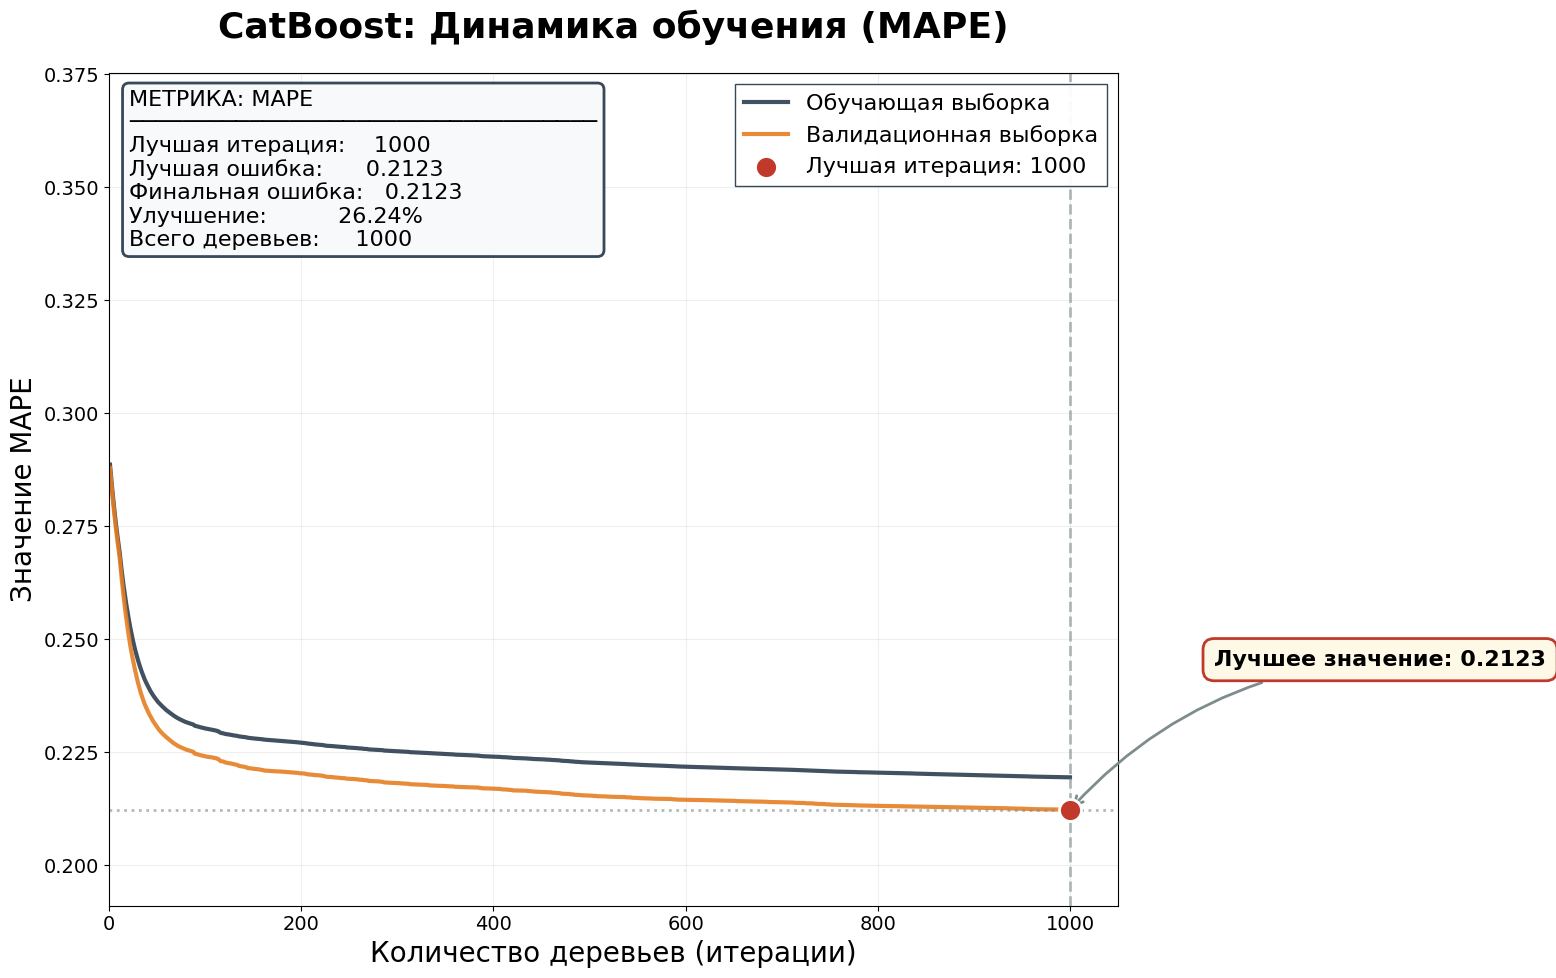

In [22]:
# Получение истории обучения
evals_result = model.get_evals_result()
metric_name = list(evals_result['learn'].keys())[0]

# Данные для графика
train_loss = evals_result['learn'][metric_name]
eval_loss = evals_result['validation'][metric_name]
iterations = range(1, len(train_loss) + 1)
best_iter = np.argmin(eval_loss) + 1
min_loss = np.min(eval_loss)
final_loss = eval_loss[-1]

# График MAPE
plt.figure(figsize=(16, 10))
plt.style.use('default')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Кривые обучения
plt.plot(iterations, train_loss, label='Обучающая выборка', 
         linewidth=3, color='#2c3e50', alpha=0.9)
plt.plot(iterations, eval_loss, label='Валидационная выборка', 
         linewidth=3, color='#e67e22', alpha=0.9)

# Отметка лучшей итерации
plt.scatter(best_iter, min_loss, color='#c0392b', s=250, zorder=5,
           label=f'Лучшая итерация: {best_iter}', edgecolor='white', linewidth=2)

# Вертикальная линия лучшей итерации
plt.axvline(x=best_iter, color='#7f8c8d', linestyle='--', linewidth=2, alpha=0.6)

# Горизонтальная линия лучшей ошибки
plt.axhline(y=min_loss, color='#7f8c8d', linestyle=':', linewidth=2, alpha=0.6)

# Информационный блок
plt.text(0.02, 0.98, 
         f'МЕТРИКА: {metric_name}\n'
         f'{"─"*35}\n'
         f'Лучшая итерация:    {best_iter}\n'
         f'Лучшая ошибка:      {min_loss:.4f}\n'
         f'Финальная ошибка:   {final_loss:.4f}\n'
         f'Улучшение:          {((eval_loss[0] - min_loss)/eval_loss[0]*100):.2f}%\n'
         f'Всего деревьев:     {len(iterations)}',
         transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.95, 
                  edgecolor='#2c3e50', linewidth=2))

# Аннотация лучшей точки
plt.annotate(f'Лучшее значение: {min_loss:.4f}', 
             xy=(best_iter, min_loss), 
             xytext=(best_iter + len(iterations)*0.15, min_loss * 1.15),
             fontsize=16, fontweight='semibold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#fef9e7', 
                      edgecolor='#c0392b', linewidth=2),
             arrowprops=dict(arrowstyle='->', color='#7f8c8d', 
                           connectionstyle='arc3,rad=0.2', linewidth=2))

# Оформление
plt.title(f'CatBoost: Динамика обучения ({metric_name})', fontsize=26, fontweight='semibold', pad=25)
plt.xlabel('Количество деревьев (итерации)', fontsize=20, fontweight='normal')
plt.ylabel(f'Значение {metric_name}', fontsize=20, fontweight='normal')

plt.legend(loc='upper right', fontsize=16, frameon=True, fancybox=False, 
          edgecolor='#2c3e50', facecolor='white', framealpha=0.95)

plt.grid(True, alpha=0.2, linestyle='-', linewidth=0.8)

# Настройка границ
y_min = min(train_loss[0], eval_loss[0], min_loss) * 0.9
y_max = max(train_loss[0], eval_loss[0]) * 1.3
plt.ylim(y_min, y_max)
plt.xlim(0, len(iterations) * 1.05)

plt.tight_layout()
plt.show()

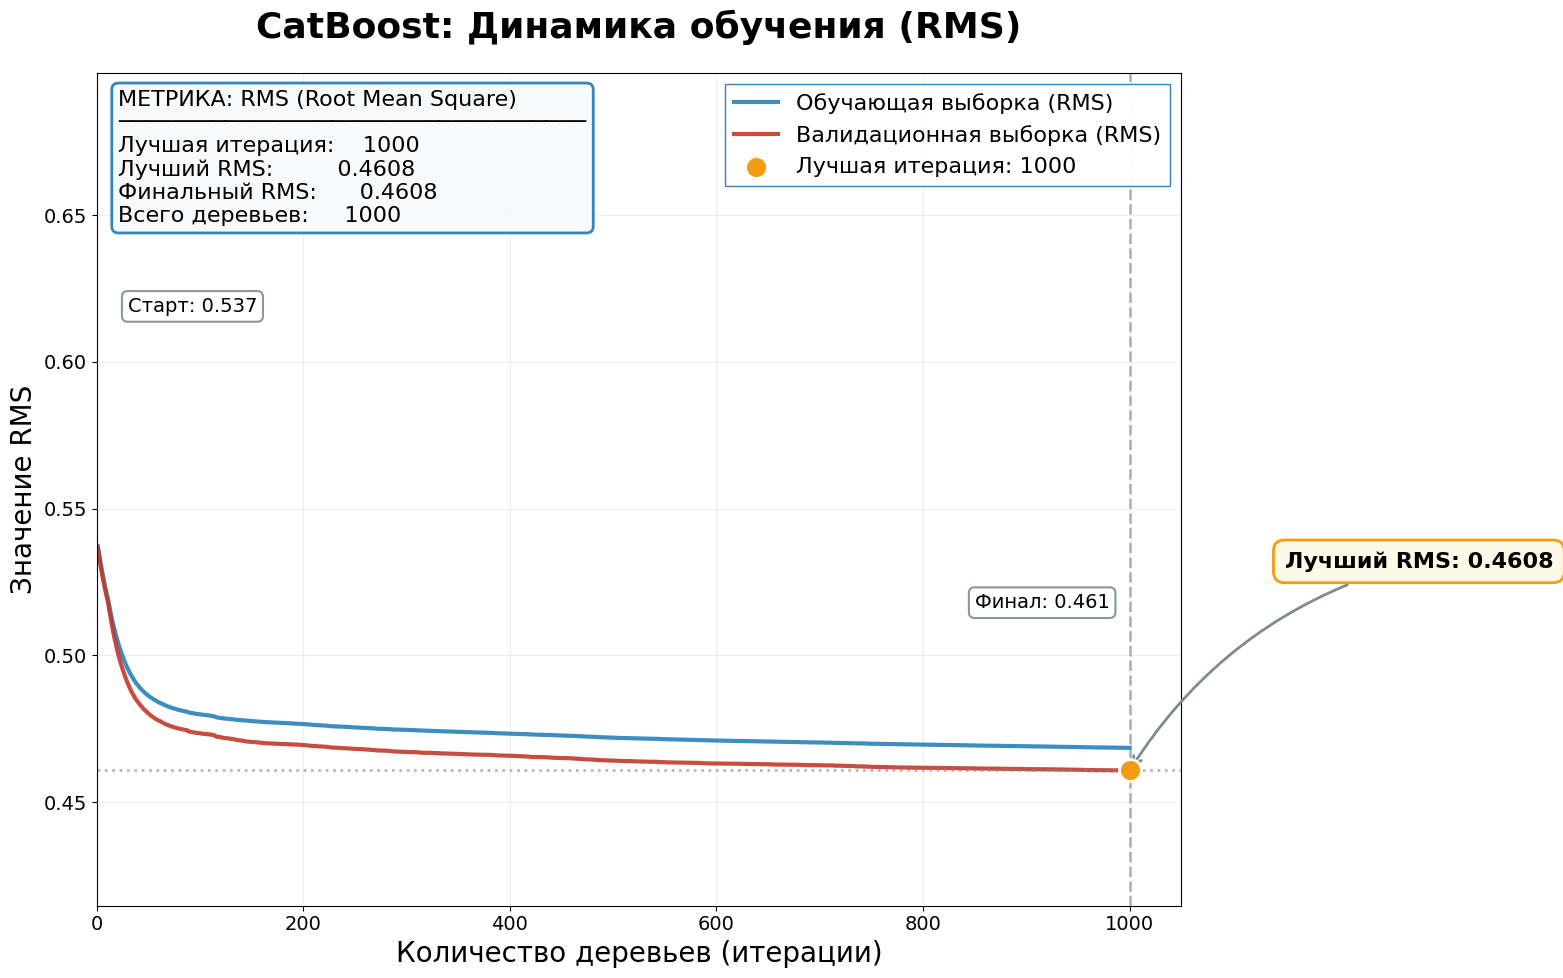

In [24]:
train_rms = np.sqrt(train_loss)
eval_rms = np.sqrt(eval_loss)
best_rms_iter = np.argmin(eval_rms) + 1
best_rms = np.min(eval_rms)
final_rms = eval_rms[-1]

# График RMS
plt.figure(figsize=(16, 10))
plt.style.use('default')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Кривые RMS
plt.plot(iterations, train_rms, label='Обучающая выборка (RMS)', 
         linewidth=3, color='#2980b9', alpha=0.9)
plt.plot(iterations, eval_rms, label='Валидационная выборка (RMS)', 
         linewidth=3, color='#c0392b', alpha=0.9)

# Отметка лучшей итерации для RMS
plt.scatter(best_rms_iter, best_rms, color='#f39c12', s=250, zorder=5,
           label=f'Лучшая итерация: {best_rms_iter}', edgecolor='white', linewidth=2)

# Вертикальная линия лучшей итерации
plt.axvline(x=best_rms_iter, color='#7f8c8d', linestyle='--', linewidth=2, alpha=0.6)

# Горизонтальная линия лучшей ошибки
plt.axhline(y=best_rms, color='#7f8c8d', linestyle=':', linewidth=2, alpha=0.6)

# Информационный блок для RMS
plt.text(0.02, 0.98, 
         f'МЕТРИКА: RMS (Root Mean Square)\n'
         f'{"─"*35}\n'
         f'Лучшая итерация:    {best_rms_iter}\n'
         f'Лучший RMS:         {best_rms:.4f}\n'
         f'Финальный RMS:      {final_rms:.4f}\n'
         f'Всего деревьев:     {len(iterations)}',
         transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.95, 
                  edgecolor='#2980b9', linewidth=2))

# Аннотация лучшей точки RMS
plt.annotate(f'Лучший RMS: {best_rms:.4f}', 
             xy=(best_rms_iter, best_rms), 
             xytext=(best_rms_iter + len(iterations)*0.15, best_rms * 1.15),
             fontsize=16, fontweight='semibold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#fef9e7', 
                      edgecolor='#f39c12', linewidth=2),
             arrowprops=dict(arrowstyle='->', color='#7f8c8d', 
                           connectionstyle='arc3,rad=0.2', linewidth=2))

# Подписи ключевых точек RMS
plt.annotate(f'Старт: {eval_rms[0]:.3f}', 
            xy=(1, eval_rms[0]),
            xytext=(30, eval_rms[0] * 1.15),
            fontsize=14,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9,
                     edgecolor='#7f8c8d', linewidth=1.5))

plt.annotate(f'Финал: {eval_rms[-1]:.3f}', 
            xy=(len(iterations), eval_rms[-1]),
            xytext=(len(iterations)-150, eval_rms[-1] * 1.12),
            fontsize=14,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9,
                     edgecolor='#7f8c8d', linewidth=1.5))


# Оформление
plt.title('CatBoost: Динамика обучения (RMS)', fontsize=26, fontweight='semibold', pad=25)
plt.xlabel('Количество деревьев (итерации)', fontsize=20, fontweight='normal')
plt.ylabel('Значение RMS', fontsize=20, fontweight='normal')

plt.legend(loc='upper right', fontsize=16, frameon=True, fancybox=False, 
          edgecolor='#2980b9', facecolor='white', framealpha=0.95)

plt.grid(True, alpha=0.2, linestyle='-', linewidth=0.8)

# Настройка границ
y_min = min(train_rms[0], eval_rms[0], best_rms) * 0.9
y_max = max(train_rms[0], eval_rms[0]) * 1.3
plt.ylim(y_min, y_max)
plt.xlim(0, len(iterations) * 1.05)

plt.tight_layout()
plt.show()


                РЕЗУЛЬТАТЫ МОДЕЛИ                 
MAE:  0.2534
RMSE: 0.3692
MAPE: 38.51%
R²:   0.4073


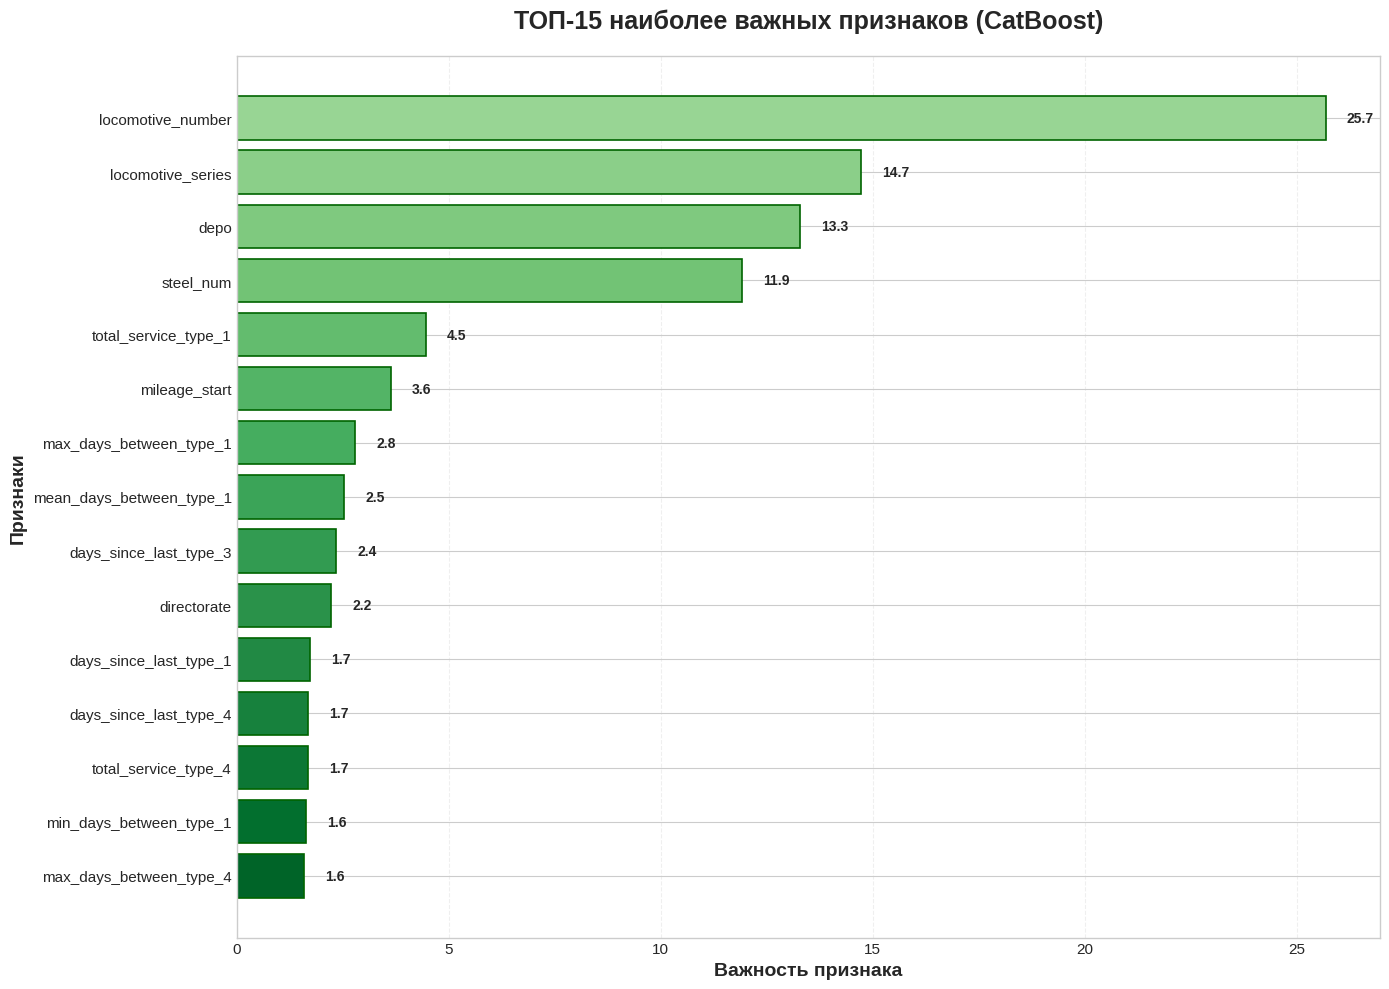

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print(f"\n{'='*50}")
print(f"РЕЗУЛЬТАТЫ МОДЕЛИ".center(50))
print(f"{'='*50}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")
print(f"{'='*50}")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=True)

top_features = feature_importance.tail(15)

plt.figure(figsize=(14, 10))
plt.style.use('seaborn-v0_8-whitegrid')
colors = plt.cm.Greens(np.linspace(0.4, 0.9, 15))

bars = plt.barh(top_features['feature'], top_features['importance'], 
                color=colors[::-1], edgecolor='darkgreen', linewidth=1.2)

for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    plt.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}', va='center', fontsize=10, fontweight='bold')

plt.title('ТОП-15 наиболее важных признаков (CatBoost)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Важность признака', fontsize=14, fontweight='semibold')
plt.ylabel('Признаки', fontsize=14, fontweight='semibold')
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
class FeatureSelectionProblem(Problem):
    def __init__(self, X_train, y_train, X_test, y_test, categorical_features, n_features):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.categorical_features = categorical_features
        self.n_features = n_features
        self.feature_names = X_train.columns.tolist()
        
        # Две цели: минимизировать MAPE и минимизировать количество признаков
        super().__init__(n_var=n_features, 
                         n_obj=2, 
                         n_constr=0,
                         xl=0, 
                         xu=1, 
                         type_var=np.bool_)
    
    def _evaluate(self, x, out, *args, **kwargs):
        n_solutions = x.shape[0]
        f1 = np.zeros(n_solutions)  # MAPE
        f2 = np.zeros(n_solutions)  # Количество признаков
        
        for i in range(n_solutions):
            selected_features = np.where(x[i] == 1)[0]
            n_selected = len(selected_features)
            
            if n_selected == 0:
                f1[i] = 100.0
                f2[i] = self.n_features
                continue
            
            X_train_selected = self.X_train.iloc[:, selected_features]
            X_test_selected = self.X_test.iloc[:, selected_features]
            
            selected_cat_features = []
            for j, feat_idx in enumerate(selected_features):
                feature_name = self.feature_names[feat_idx]
                if feature_name in self.categorical_features:
                    selected_cat_features.append(j)
            
            try:
                model = CatBoostRegressor(
                    iterations=100,
                    learning_rate=0.03,
                    depth=4,
                    l2_leaf_reg=3.0,
                    loss_function='RMSE',
                    eval_metric='MAPE',
                    random_seed=42,
                    verbose=0
                )
                
                model.fit(
                    X_train_selected, 
                    self.y_train,
                    eval_set=(X_test_selected, self.y_test),
                    cat_features=selected_cat_features if selected_cat_features else None,
                    verbose=False
                )
                
                y_pred = model.predict(X_test_selected)
                
                mask = self.y_test != 0
                if mask.sum() > 0:
                    mape = np.mean(np.abs((self.y_test[mask] - y_pred[mask]) / self.y_test[mask])) * 100
                else:
                    mape = 100.0
                    
                f1[i] = mape
                f2[i] = n_selected
                
            except Exception as e:
                print(f"Ошибка при обучении: {e}")
                f1[i] = 100.0
                f2[i] = self.n_features
        
        out["F"] = np.column_stack([f1, f2])

In [ ]:
problem = FeatureSelectionProblem(
    X_train, y_train, X_test, y_test, 
    categorical_features, 
    len(X_train.columns)
)

algorithm = NSGA2(
    pop_size=50,
    sampling=BinaryRandomSampling(),
    crossover=PointCrossover(prob=0.9, n_points=2),
    mutation=BitflipMutation(prob=0.1),
    eliminate_duplicates=True
)

In [ ]:
print("=== ЗАПУСК NSGA-II ДЛЯ ПОДБОРА ПРИЗНАКОВ ===")

termination = get_termination("n_gen", 30) 
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

=== ЗАПУСК NSGA-II ДЛЯ ПОДБОРА ПРИЗНАКОВ ===


n=== РЕЗУЛЬТАТЫ NSGA-II ===
Найдено решений на фронте Парето: 10

Топ-5 решений (по MAPE):

Решение 1:
  MAPE: 42.29%
  Количество признаков: 13.0 из 31
  Выбранные признаки: locomotive_series, locomotive_number, depo, steel_num, mileage_start, total_service_type_1, total_service_type_4, days_since_last_type_4, mean_days_between_type_1, mean_days_between_type_3...

Решение 2:
  MAPE: 42.31%
  Количество признаков: 7.0 из 31
  Выбранные признаки: locomotive_series, locomotive_number, depo, steel_num, mileage_start, directorate, total_service_type_4

Решение 3:
  MAPE: 42.39%
  Количество признаков: 6.0 из 31
  Выбранные признаки: locomotive_series, locomotive_number, depo, steel_num, mean_days_between_type_3, age_days

Решение 4:
  MAPE: 42.39%
  Количество признаков: 6.0 из 31
  Выбранные признаки: locomotive_series, locomotive_number, depo, steel_num, total_service_type_3, min_days_between_type_2

Решение 5:
  MAPE: 42.39%
  Количество признаков: 6.0 из 31
  Выбранные признаки: locomo

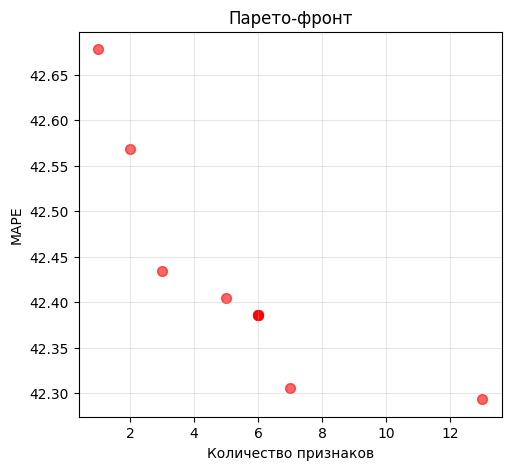

In [ ]:
print("n=== РЕЗУЛЬТАТЫ NSGA-II ===")
print(f"Найдено решений на фронте Парето: {len(res.F)}")

pareto_solutions = []
for i in range(len(res.F)):
    pareto_solutions.append({
        'mape': res.F[i, 0],
        'n_features': res.F[i, 1],
        'features_mask': res.X[i]
    })

pareto_solutions.sort(key=lambda x: x['mape'])

print("\nТоп-5 решений (по MAPE):")
for i, sol in enumerate(pareto_solutions[:5]):
    selected_features = [problem.feature_names[j] for j in range(len(sol['features_mask'])) if sol['features_mask'][j] == 1]
    print(f"\nРешение {i+1}:")
    print(f"  MAPE: {sol['mape']:.2f}%")
    print(f"  Количество признаков: {sol['n_features']} из {problem.n_features}")
    print(f"  Выбранные признаки: {', '.join(selected_features[:10])}{'...' if len(selected_features) > 10 else ''}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter([s['n_features'] for s in pareto_solutions], 
           [s['mape']/100 for s in pareto_solutions], 
           c='red', s=50, alpha=0.6)
plt.xlabel('Количество признаков')
plt.ylabel('MAPE')
plt.title('Парето-фронт')
plt.grid(True, alpha=0.3)

In [ ]:
best_solution = pareto_solutions[0]
for sol in pareto_solutions:
    if sol['mape'] < best_solution['mape']:
        best_solution = sol

selected_features_idx = np.where(best_solution['features_mask'] == 1)[0]
selected_feature_names = [problem.feature_names[j] for j in selected_features_idx]

print("\n=== ФИНАЛЬНАЯ МОДЕЛЬ С ОПТИМАЛЬНЫМИ ПРИЗНАКАМИ ===")
print(f"Выбрано признаков: {len(selected_feature_names)} из {problem.n_features}")
print(f"Ожидаемый MAPE: {best_solution['mape']:.2f}%")

X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

selected_cat_features = [i for i, feat in enumerate(selected_feature_names) 
                        if feat in categorical_features]

final_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    eval_metric='MAPE',
    random_seed=42,
    verbose=100
)

final_model.fit(
    X_train_selected, 
    y_train,
    eval_set=(X_test_selected, y_test),
    cat_features=selected_cat_features if selected_cat_features else None
)

y_pred_final = final_model.predict(X_test_selected)

print(f"\n=== РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ МОДЕЛИ ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_final):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_final)):.4f}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100:.2f}%")
print(f"R²: {r2_score(y_test, y_pred_final):.4f}")


=== ФИНАЛЬНАЯ МОДЕЛЬ С ОПТИМАЛЬНЫМИ ПРИЗНАКАМИ ===
Выбрано признаков: 13 из 31
Ожидаемый MAPE: 42.29%
0:	learn: 0.2886491	test: 0.2879123	best: 0.2879123 (0)	total: 61.4ms	remaining: 1m 1s
100:	learn: 0.2302448	test: 0.2241690	best: 0.2241690 (100)	total: 4.58s	remaining: 40.8s
200:	learn: 0.2269551	test: 0.2199631	best: 0.2199631 (200)	total: 11.2s	remaining: 44.4s
300:	learn: 0.2251868	test: 0.2177956	best: 0.2177956 (300)	total: 17.8s	remaining: 41.3s
400:	learn: 0.2240504	test: 0.2166062	best: 0.2166062 (400)	total: 23.4s	remaining: 34.9s
500:	learn: 0.2229726	test: 0.2153478	best: 0.2153478 (500)	total: 28.7s	remaining: 28.6s
600:	learn: 0.2220944	test: 0.2143999	best: 0.2143999 (600)	total: 34.1s	remaining: 22.6s
700:	learn: 0.2214761	test: 0.2138472	best: 0.2138472 (700)	total: 41.2s	remaining: 17.6s
800:	learn: 0.2208626	test: 0.2132352	best: 0.2132352 (800)	total: 47.6s	remaining: 11.8s
900:	learn: 0.2203809	test: 0.2127926	best: 0.2127926 (900)	total: 53.4s	remaining: 5.87s
